# CNN on CIFAR10

In [34]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision

In [35]:
# Training settings
batch_size = 64

## Load the dataset

The dataset are stored somewhere on a server and can be downloaded like below

In [36]:
# MNIST Dataset
train_dataset = datasets.CIFAR10(root='./data/',
                               train=True, # represents the training section of the data
                               transform=transforms.ToTensor(),
                               download=True)

Extracting ./data/cifar-10-python.tar.gz to ./data/


In [38]:
test_dataset = datasets.CIFAR10(root='./data/',
                              train=False, #validation set 
                              transform=transforms.ToTensor())
print(test_dataset[0])

(tensor([[[0.6196, 0.6235, 0.6471,  ..., 0.5373, 0.4941, 0.4549],
         [0.5961, 0.5922, 0.6235,  ..., 0.5333, 0.4902, 0.4667],
         [0.5922, 0.5922, 0.6196,  ..., 0.5451, 0.5098, 0.4706],
         ...,
         [0.2667, 0.1647, 0.1216,  ..., 0.1490, 0.0510, 0.1569],
         [0.2392, 0.1922, 0.1373,  ..., 0.1020, 0.1137, 0.0784],
         [0.2118, 0.2196, 0.1765,  ..., 0.0941, 0.1333, 0.0824]],

        [[0.4392, 0.4353, 0.4549,  ..., 0.3725, 0.3569, 0.3333],
         [0.4392, 0.4314, 0.4471,  ..., 0.3725, 0.3569, 0.3451],
         [0.4314, 0.4275, 0.4353,  ..., 0.3843, 0.3725, 0.3490],
         ...,
         [0.4863, 0.3922, 0.3451,  ..., 0.3804, 0.2510, 0.3333],
         [0.4549, 0.4000, 0.3333,  ..., 0.3216, 0.3216, 0.2510],
         [0.4196, 0.4118, 0.3490,  ..., 0.3020, 0.3294, 0.2627]],

        [[0.1922, 0.1843, 0.2000,  ..., 0.1412, 0.1412, 0.1294],
         [0.2000, 0.1569, 0.1765,  ..., 0.1216, 0.1255, 0.1333],
         [0.1843, 0.1294, 0.1412,  ..., 0.1333, 0.1333, 0

Use Loaders for the dataset so it can use mini batch for training and testing

In [39]:
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

In [40]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

Take a look on how the data looks like

  dog automobile   dog  deer   dog truck  deer  ship   dog  bird  ship airplane  ship automobile  deer  bird  frog  deer  deer truck  bird   cat truck   cat automobile automobile   cat horse  deer   dog horse horse airplane  bird automobile   dog  bird truck airplane   cat  bird truck  deer   cat airplane  frog automobile horse  deer  ship airplane truck   dog airplane   dog   cat   dog airplane  bird horse airplane  ship horse horse


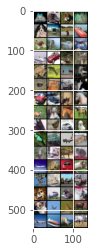

In [42]:
def plot_images(images, labels): 
    # normalise=True below shifts [-1,1] to [0,1]
    img_grid = torchvision.utils.make_grid(images, nrow=4, normalize=True)
    np_img = img_grid.numpy().transpose(1,2,0)  
    plt.imshow(np_img)
    
d_class2idx = train_dataset.class_to_idx
d_idx2class = dict(zip(d_class2idx.values(),d_class2idx.keys()))
train_iter = iter(train_loader)
images, labels = train_iter.next()
plot_images(images,labels)
print(' '.join('%5s' % d_idx2class[int(labels[j])]for j in range(len(images))))

Generate the structure of the CNN.

I have 2 convolutional layers. The first one has 3 input channels, because the dataset contain color images, and 10 output channels.
The 2nd 10 input and 20 output. 
The last 2 layers are 2 fully conected linear layers. The last one has 10 neurons because the dataset has 10 different categories

In [141]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        '''
        nn.Conv2d(in_channels, out_channels, kernel_size)
        in_channels - number of channels of the input
                    - for greyscale images we have 1, or basically a single channel
                    - for RGB images we have 3 channels and for sattelite date number can be higher.
        
        out_channels - number of different filters applied to the input images and the resulting images from the operation
                     - in our case is 10 at first conv, so we will have 10 different images as a result of filters applied
        '''
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.mp = nn.MaxPool2d(2) # apply max pool with a window of 2X2
        self.fc = nn.Linear(500, 200) # final fully-connected layer
        self.fc2 = nn.Linear(200, 10) # final fully-connected layer
        
    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv1(x)))
        x = F.relu(self.mp(self.conv2(x)))
        x = x.view(in_size, -1)  # flatten the tensor
        x = self.fc(x)
        x = self.fc2(x)
        return x

In [151]:
model = Net()

In [152]:
print(model)

Net(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=500, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
)


In [153]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

In [154]:
train_loss = []
validation_loss=[]
validation_accuracy=[]
train_accuracy=[]

## Training

In [155]:
def train(epoch):
    model.train()
    correct = 0
    losses=[]
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_loss.append(sum(losses)/len(losses))
    train_accuracy.append(correct* 100./len(train_loader.dataset))

## Testing

In [156]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    losses=[]
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            # sum up batch loss
            loss= criterion(output, target)
            losses.append(loss.item())
            # get the index of the max log-probability
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        test_loss = sum(losses)/len(losses)
        validation_loss.append(test_loss)
        validation_accuracy.append(100. * correct/len(test_loader.dataset))
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))


In [157]:
for epoch in range(1, 20):
    train(epoch)
    test()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.301928
Train Epoch: 1 [640/50000 (1%)]	Loss: 2.300784
Train Epoch: 1 [1280/50000 (3%)]	Loss: 2.301842
Train Epoch: 1 [1920/50000 (4%)]	Loss: 2.302624
Train Epoch: 1 [2560/50000 (5%)]	Loss: 2.302539
Train Epoch: 1 [3200/50000 (6%)]	Loss: 2.305188
Train Epoch: 1 [3840/50000 (8%)]	Loss: 2.298910
Train Epoch: 1 [4480/50000 (9%)]	Loss: 2.305188
Train Epoch: 1 [5120/50000 (10%)]	Loss: 2.295087
Train Epoch: 1 [5760/50000 (12%)]	Loss: 2.301746
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.303147
Train Epoch: 1 [7040/50000 (14%)]	Loss: 2.297650
Train Epoch: 1 [7680/50000 (15%)]	Loss: 2.298273
Train Epoch: 1 [8320/50000 (17%)]	Loss: 2.299723
Train Epoch: 1 [8960/50000 (18%)]	Loss: 2.295755
Train Epoch: 1 [9600/50000 (19%)]	Loss: 2.295446
Train Epoch: 1 [10240/50000 (20%)]	Loss: 2.298668
Train Epoch: 1 [10880/50000 (22%)]	Loss: 2.291656
Train Epoch: 1 [11520/50000 (23%)]	Loss: 2.290133
Train Epoch: 1 [12160/50000 (24%)]	Loss: 2.292207
Train Epoch: 1 [12800/50000 

Train Epoch: 3 [3200/50000 (6%)]	Loss: 1.569742
Train Epoch: 3 [3840/50000 (8%)]	Loss: 1.709843
Train Epoch: 3 [4480/50000 (9%)]	Loss: 1.607103
Train Epoch: 3 [5120/50000 (10%)]	Loss: 1.403438
Train Epoch: 3 [5760/50000 (12%)]	Loss: 1.443710
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.735602
Train Epoch: 3 [7040/50000 (14%)]	Loss: 1.590259
Train Epoch: 3 [7680/50000 (15%)]	Loss: 1.483956
Train Epoch: 3 [8320/50000 (17%)]	Loss: 1.469798
Train Epoch: 3 [8960/50000 (18%)]	Loss: 1.564213
Train Epoch: 3 [9600/50000 (19%)]	Loss: 1.597003
Train Epoch: 3 [10240/50000 (20%)]	Loss: 1.469701
Train Epoch: 3 [10880/50000 (22%)]	Loss: 1.727248
Train Epoch: 3 [11520/50000 (23%)]	Loss: 1.363799
Train Epoch: 3 [12160/50000 (24%)]	Loss: 1.446278
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.717102
Train Epoch: 3 [13440/50000 (27%)]	Loss: 1.508762
Train Epoch: 3 [14080/50000 (28%)]	Loss: 1.498980
Train Epoch: 3 [14720/50000 (29%)]	Loss: 1.504585
Train Epoch: 3 [15360/50000 (31%)]	Loss: 1.490597
Train Epoch: 3

Train Epoch: 5 [6400/50000 (13%)]	Loss: 1.326034
Train Epoch: 5 [7040/50000 (14%)]	Loss: 1.375065
Train Epoch: 5 [7680/50000 (15%)]	Loss: 1.203918
Train Epoch: 5 [8320/50000 (17%)]	Loss: 1.385811
Train Epoch: 5 [8960/50000 (18%)]	Loss: 1.411352
Train Epoch: 5 [9600/50000 (19%)]	Loss: 1.362749
Train Epoch: 5 [10240/50000 (20%)]	Loss: 1.491724
Train Epoch: 5 [10880/50000 (22%)]	Loss: 1.343924
Train Epoch: 5 [11520/50000 (23%)]	Loss: 1.274480
Train Epoch: 5 [12160/50000 (24%)]	Loss: 1.371672
Train Epoch: 5 [12800/50000 (26%)]	Loss: 1.522960
Train Epoch: 5 [13440/50000 (27%)]	Loss: 1.458443
Train Epoch: 5 [14080/50000 (28%)]	Loss: 1.339370
Train Epoch: 5 [14720/50000 (29%)]	Loss: 1.565912
Train Epoch: 5 [15360/50000 (31%)]	Loss: 1.388352
Train Epoch: 5 [16000/50000 (32%)]	Loss: 1.426745
Train Epoch: 5 [16640/50000 (33%)]	Loss: 1.362058
Train Epoch: 5 [17280/50000 (35%)]	Loss: 1.366040
Train Epoch: 5 [17920/50000 (36%)]	Loss: 1.470557
Train Epoch: 5 [18560/50000 (37%)]	Loss: 1.393741
Train 

Train Epoch: 7 [9600/50000 (19%)]	Loss: 1.369477
Train Epoch: 7 [10240/50000 (20%)]	Loss: 1.363192
Train Epoch: 7 [10880/50000 (22%)]	Loss: 1.319340
Train Epoch: 7 [11520/50000 (23%)]	Loss: 1.173420
Train Epoch: 7 [12160/50000 (24%)]	Loss: 1.337118
Train Epoch: 7 [12800/50000 (26%)]	Loss: 1.381155
Train Epoch: 7 [13440/50000 (27%)]	Loss: 1.181977
Train Epoch: 7 [14080/50000 (28%)]	Loss: 1.046629
Train Epoch: 7 [14720/50000 (29%)]	Loss: 1.060821
Train Epoch: 7 [15360/50000 (31%)]	Loss: 1.315010
Train Epoch: 7 [16000/50000 (32%)]	Loss: 1.277052
Train Epoch: 7 [16640/50000 (33%)]	Loss: 1.532335
Train Epoch: 7 [17280/50000 (35%)]	Loss: 1.417487
Train Epoch: 7 [17920/50000 (36%)]	Loss: 1.269524
Train Epoch: 7 [18560/50000 (37%)]	Loss: 1.308785
Train Epoch: 7 [19200/50000 (38%)]	Loss: 1.378495
Train Epoch: 7 [19840/50000 (40%)]	Loss: 1.226038
Train Epoch: 7 [20480/50000 (41%)]	Loss: 1.333292
Train Epoch: 7 [21120/50000 (42%)]	Loss: 1.112462
Train Epoch: 7 [21760/50000 (43%)]	Loss: 1.246705
T

Train Epoch: 9 [12800/50000 (26%)]	Loss: 1.114594
Train Epoch: 9 [13440/50000 (27%)]	Loss: 1.188571
Train Epoch: 9 [14080/50000 (28%)]	Loss: 1.195428
Train Epoch: 9 [14720/50000 (29%)]	Loss: 1.205072
Train Epoch: 9 [15360/50000 (31%)]	Loss: 1.196107
Train Epoch: 9 [16000/50000 (32%)]	Loss: 1.097906
Train Epoch: 9 [16640/50000 (33%)]	Loss: 1.014249
Train Epoch: 9 [17280/50000 (35%)]	Loss: 0.916529
Train Epoch: 9 [17920/50000 (36%)]	Loss: 1.234431
Train Epoch: 9 [18560/50000 (37%)]	Loss: 1.250025
Train Epoch: 9 [19200/50000 (38%)]	Loss: 1.224555
Train Epoch: 9 [19840/50000 (40%)]	Loss: 1.116128
Train Epoch: 9 [20480/50000 (41%)]	Loss: 1.202064
Train Epoch: 9 [21120/50000 (42%)]	Loss: 1.124042
Train Epoch: 9 [21760/50000 (43%)]	Loss: 1.280015
Train Epoch: 9 [22400/50000 (45%)]	Loss: 1.369381
Train Epoch: 9 [23040/50000 (46%)]	Loss: 1.256053
Train Epoch: 9 [23680/50000 (47%)]	Loss: 1.296738
Train Epoch: 9 [24320/50000 (49%)]	Loss: 1.198842
Train Epoch: 9 [24960/50000 (50%)]	Loss: 1.284194


Train Epoch: 11 [14720/50000 (29%)]	Loss: 0.950152
Train Epoch: 11 [15360/50000 (31%)]	Loss: 1.153007
Train Epoch: 11 [16000/50000 (32%)]	Loss: 0.891076
Train Epoch: 11 [16640/50000 (33%)]	Loss: 1.137521
Train Epoch: 11 [17280/50000 (35%)]	Loss: 1.026511
Train Epoch: 11 [17920/50000 (36%)]	Loss: 0.918362
Train Epoch: 11 [18560/50000 (37%)]	Loss: 1.190486
Train Epoch: 11 [19200/50000 (38%)]	Loss: 1.340015
Train Epoch: 11 [19840/50000 (40%)]	Loss: 1.270606
Train Epoch: 11 [20480/50000 (41%)]	Loss: 1.018042
Train Epoch: 11 [21120/50000 (42%)]	Loss: 1.234256
Train Epoch: 11 [21760/50000 (43%)]	Loss: 1.034201
Train Epoch: 11 [22400/50000 (45%)]	Loss: 1.417386
Train Epoch: 11 [23040/50000 (46%)]	Loss: 1.224459
Train Epoch: 11 [23680/50000 (47%)]	Loss: 1.170310
Train Epoch: 11 [24320/50000 (49%)]	Loss: 1.377514
Train Epoch: 11 [24960/50000 (50%)]	Loss: 1.095325
Train Epoch: 11 [25600/50000 (51%)]	Loss: 1.113628
Train Epoch: 11 [26240/50000 (52%)]	Loss: 1.083194
Train Epoch: 11 [26880/50000 (5

Train Epoch: 13 [16000/50000 (32%)]	Loss: 1.219166
Train Epoch: 13 [16640/50000 (33%)]	Loss: 1.282118
Train Epoch: 13 [17280/50000 (35%)]	Loss: 1.318401
Train Epoch: 13 [17920/50000 (36%)]	Loss: 1.170254
Train Epoch: 13 [18560/50000 (37%)]	Loss: 0.941081
Train Epoch: 13 [19200/50000 (38%)]	Loss: 1.013223
Train Epoch: 13 [19840/50000 (40%)]	Loss: 1.235280
Train Epoch: 13 [20480/50000 (41%)]	Loss: 0.869880
Train Epoch: 13 [21120/50000 (42%)]	Loss: 1.010525
Train Epoch: 13 [21760/50000 (43%)]	Loss: 1.220642
Train Epoch: 13 [22400/50000 (45%)]	Loss: 1.075272
Train Epoch: 13 [23040/50000 (46%)]	Loss: 1.038542
Train Epoch: 13 [23680/50000 (47%)]	Loss: 0.887580
Train Epoch: 13 [24320/50000 (49%)]	Loss: 1.209611
Train Epoch: 13 [24960/50000 (50%)]	Loss: 1.229538
Train Epoch: 13 [25600/50000 (51%)]	Loss: 1.292230
Train Epoch: 13 [26240/50000 (52%)]	Loss: 1.168559
Train Epoch: 13 [26880/50000 (54%)]	Loss: 1.094499
Train Epoch: 13 [27520/50000 (55%)]	Loss: 1.139557
Train Epoch: 13 [28160/50000 (5

Train Epoch: 15 [17280/50000 (35%)]	Loss: 0.883530
Train Epoch: 15 [17920/50000 (36%)]	Loss: 1.197088
Train Epoch: 15 [18560/50000 (37%)]	Loss: 0.959885
Train Epoch: 15 [19200/50000 (38%)]	Loss: 1.024413
Train Epoch: 15 [19840/50000 (40%)]	Loss: 1.192828
Train Epoch: 15 [20480/50000 (41%)]	Loss: 1.003317
Train Epoch: 15 [21120/50000 (42%)]	Loss: 0.788643
Train Epoch: 15 [21760/50000 (43%)]	Loss: 1.216811
Train Epoch: 15 [22400/50000 (45%)]	Loss: 0.862832
Train Epoch: 15 [23040/50000 (46%)]	Loss: 1.171354
Train Epoch: 15 [23680/50000 (47%)]	Loss: 0.882648
Train Epoch: 15 [24320/50000 (49%)]	Loss: 0.661113
Train Epoch: 15 [24960/50000 (50%)]	Loss: 1.078216
Train Epoch: 15 [25600/50000 (51%)]	Loss: 0.915220
Train Epoch: 15 [26240/50000 (52%)]	Loss: 1.077051
Train Epoch: 15 [26880/50000 (54%)]	Loss: 1.294612
Train Epoch: 15 [27520/50000 (55%)]	Loss: 1.093709
Train Epoch: 15 [28160/50000 (56%)]	Loss: 1.223658
Train Epoch: 15 [28800/50000 (58%)]	Loss: 1.012250
Train Epoch: 15 [29440/50000 (5

Train Epoch: 17 [18560/50000 (37%)]	Loss: 0.976189
Train Epoch: 17 [19200/50000 (38%)]	Loss: 1.053780
Train Epoch: 17 [19840/50000 (40%)]	Loss: 0.954492
Train Epoch: 17 [20480/50000 (41%)]	Loss: 0.962680
Train Epoch: 17 [21120/50000 (42%)]	Loss: 1.050521
Train Epoch: 17 [21760/50000 (43%)]	Loss: 0.938035
Train Epoch: 17 [22400/50000 (45%)]	Loss: 0.990414
Train Epoch: 17 [23040/50000 (46%)]	Loss: 1.157680
Train Epoch: 17 [23680/50000 (47%)]	Loss: 1.011273
Train Epoch: 17 [24320/50000 (49%)]	Loss: 1.021788
Train Epoch: 17 [24960/50000 (50%)]	Loss: 0.973402
Train Epoch: 17 [25600/50000 (51%)]	Loss: 1.035707
Train Epoch: 17 [26240/50000 (52%)]	Loss: 1.205335
Train Epoch: 17 [26880/50000 (54%)]	Loss: 1.032197
Train Epoch: 17 [27520/50000 (55%)]	Loss: 1.007087
Train Epoch: 17 [28160/50000 (56%)]	Loss: 1.178365
Train Epoch: 17 [28800/50000 (58%)]	Loss: 1.056556
Train Epoch: 17 [29440/50000 (59%)]	Loss: 1.057124
Train Epoch: 17 [30080/50000 (60%)]	Loss: 1.187232
Train Epoch: 17 [30720/50000 (6

Train Epoch: 19 [19840/50000 (40%)]	Loss: 1.060799
Train Epoch: 19 [20480/50000 (41%)]	Loss: 1.355505
Train Epoch: 19 [21120/50000 (42%)]	Loss: 0.784906
Train Epoch: 19 [21760/50000 (43%)]	Loss: 0.879777
Train Epoch: 19 [22400/50000 (45%)]	Loss: 1.167040
Train Epoch: 19 [23040/50000 (46%)]	Loss: 1.386257
Train Epoch: 19 [23680/50000 (47%)]	Loss: 0.956447
Train Epoch: 19 [24320/50000 (49%)]	Loss: 0.794284
Train Epoch: 19 [24960/50000 (50%)]	Loss: 0.830443
Train Epoch: 19 [25600/50000 (51%)]	Loss: 0.970641
Train Epoch: 19 [26240/50000 (52%)]	Loss: 1.008885
Train Epoch: 19 [26880/50000 (54%)]	Loss: 1.428949
Train Epoch: 19 [27520/50000 (55%)]	Loss: 0.951517
Train Epoch: 19 [28160/50000 (56%)]	Loss: 0.911294
Train Epoch: 19 [28800/50000 (58%)]	Loss: 1.131400
Train Epoch: 19 [29440/50000 (59%)]	Loss: 0.859599
Train Epoch: 19 [30080/50000 (60%)]	Loss: 0.870010
Train Epoch: 19 [30720/50000 (61%)]	Loss: 0.938226
Train Epoch: 19 [31360/50000 (63%)]	Loss: 1.445002
Train Epoch: 19 [32000/50000 (6

In [158]:
#matplotlib este folosit pentru a realiza grafice
import matplotlib.pyplot as plt
plt.style.use("ggplot")

## Verify results

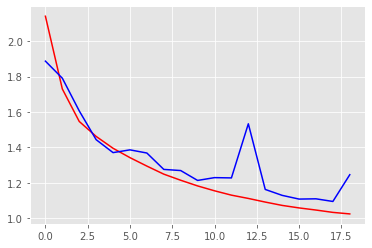

In [159]:
# Printăm comparativ cu roșu loss-ul de pe setul de validare și cu albastru loss-ul de pe setul de validare.
plt.plot(train_loss, "r-", validation_loss, "b-")

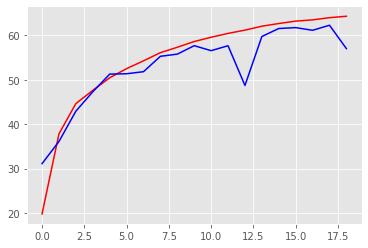

In [160]:
plt.plot(train_accuracy, "r-", validation_accuracy, "b-")